Using device: cuda
Starting PPO agent experiment with LSTM policy for SBEOS environment

=== Training Phase ===
State dimension: 31, Action dimension: 2


d:\Projects\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training PPO with LSTM:   2%|▏         | 10/500 [01:07<44:19,  5.43s/it] 

Episode: 10, Reward: 1505.00, Avg Reward (last 10): 1302.50, Accuracy: 0.5340, Steps: 500
New best model saved! Avg reward: 1302.50


Training PPO with LSTM:   3%|▎         | 15/500 [01:45<55:09,  6.82s/it]  

New best model saved! Avg reward: 1311.50


Training PPO with LSTM:   3%|▎         | 16/500 [01:51<54:15,  6.73s/it]

New best model saved! Avg reward: 1329.50


Training PPO with LSTM:   4%|▍         | 19/500 [02:14<58:00,  7.24s/it]

Episode: 20, Reward: 1535.00, Avg Reward (last 10): 1317.50, Accuracy: 0.5380, Steps: 500


Training PPO with LSTM:   4%|▍         | 20/500 [02:25<1:07:27,  8.43s/it]

Evaluation at episode 20: Reward = 495.00


Training PPO with LSTM:   4%|▍         | 21/500 [02:33<1:04:54,  8.13s/it]

New best model saved! Avg reward: 1332.50


Training PPO with LSTM:   5%|▌         | 27/500 [03:11<57:22,  7.28s/it]  

New best model saved! Avg reward: 1337.00


Training PPO with LSTM:   6%|▌         | 30/500 [03:30<48:58,  6.25s/it]  

Episode: 30, Reward: 1115.00, Avg Reward (last 10): 1236.50, Accuracy: 0.4820, Steps: 500


Training PPO with LSTM:   8%|▊         | 39/500 [04:32<50:28,  6.57s/it]

Episode: 40, Reward: 1145.00, Avg Reward (last 10): 1331.00, Accuracy: 0.4860, Steps: 500


Training PPO with LSTM:   8%|▊         | 40/500 [04:38<50:09,  6.54s/it]

Evaluation at episode 40: Reward = 1740.00


Training PPO with LSTM:   8%|▊         | 41/500 [04:43<45:34,  5.96s/it]

New best model saved! Avg reward: 1395.50


Training PPO with LSTM:   9%|▉         | 46/500 [05:18<54:36,  7.22s/it]

New best model saved! Avg reward: 1485.50


Training PPO with LSTM:   9%|▉         | 47/500 [05:26<55:47,  7.39s/it]

New best model saved! Avg reward: 1491.50


Training PPO with LSTM:  10%|█         | 50/500 [05:43<44:13,  5.90s/it]

Episode: 50, Reward: 1520.00, Avg Reward (last 10): 1496.00, Accuracy: 0.5360, Steps: 500
New best model saved! Avg reward: 1496.00


Training PPO with LSTM:  12%|█▏        | 59/500 [06:31<47:49,  6.51s/it]

Episode: 60, Reward: 2540.00, Avg Reward (last 10): 1250.00, Accuracy: 0.6720, Steps: 500


Training PPO with LSTM:  12%|█▏        | 60/500 [06:43<1:00:07,  8.20s/it]

Evaluation at episode 60: Reward = 1230.00


Training PPO with LSTM:  14%|█▍        | 70/500 [07:28<26:55,  3.76s/it]  

Episode: 70, Reward: 1520.00, Avg Reward (last 10): 1386.50, Accuracy: 0.5360, Steps: 500


Training PPO with LSTM:  16%|█▌        | 79/500 [08:04<43:00,  6.13s/it]

Episode: 80, Reward: 725.00, Avg Reward (last 10): 1010.00, Accuracy: 0.4300, Steps: 500
Early stopping after 80 episodes - no improvement for 30 episodes
Training completed. Final accuracy: 0.5055


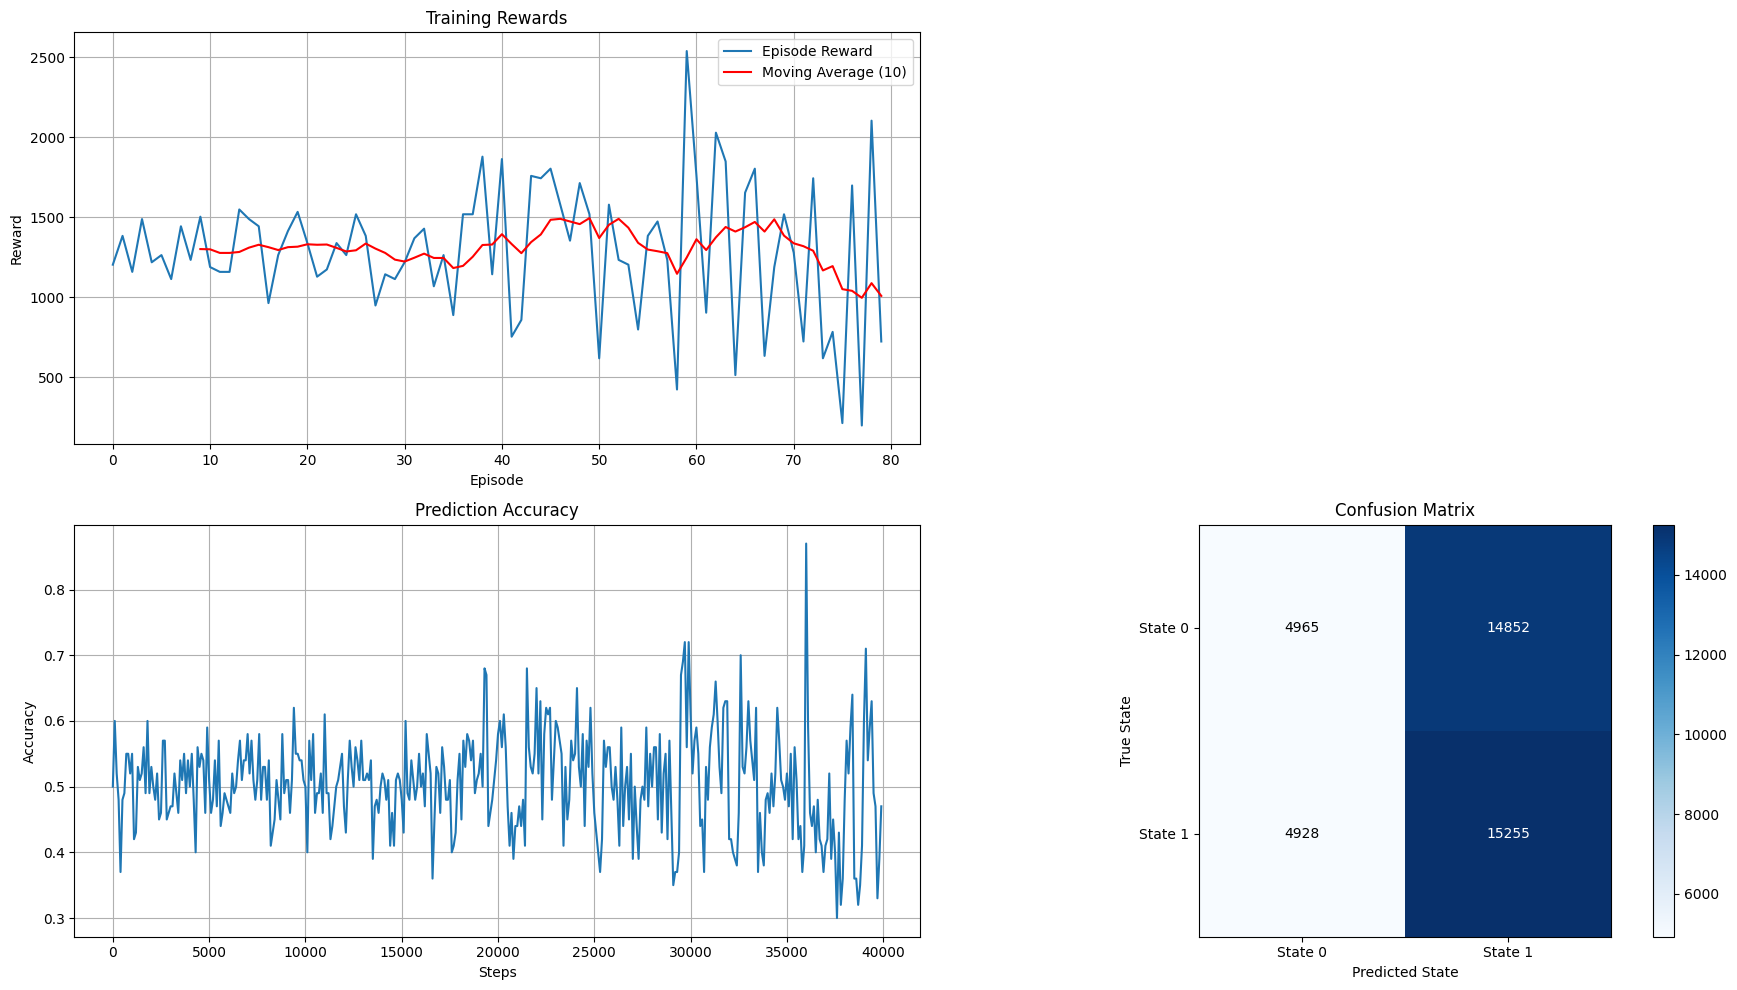

Final evaluation - Average reward over 20 episodes: 968.25

=== Testing Phase ===

Evaluating on test environment...
Test episode 10/100 completed. Reward: 1035.00
Test episode 20/100 completed. Reward: -30.00
Test episode 30/100 completed. Reward: 720.00
Test episode 40/100 completed. Reward: 1665.00


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_curve
from tqdm import tqdm
import pandas as pd
from scipy.stats import entropy
import copy
import math
from environments import SBEOS_Environment

# Set seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define a transition tuple for PPO memory
Transition = namedtuple('Transition', 
                        ('state', 'action', 'reward', 'next_state', 'done', 'log_prob', 'value'))

class PPOMemory:
    """Memory buffer for PPO algorithm"""
    def __init__(self, capacity=2000):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        """Save a transition to the memory buffer"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self):
        """Return all transitions in the buffer"""
        return Transition(*zip(*self.memory))
    
    def clear(self):
        """Clear the memory buffer"""
        self.memory = []
        self.position = 0
    
    def __len__(self):
        return len(self.memory)

class LSTMFeatureExtractor(nn.Module):
    """LSTM-based feature extractor for processing sequential data"""
    def __init__(self, state_size, hidden_dim=64, num_layers=2):
        super(LSTMFeatureExtractor, self).__init__()
        
        # Separate parts of the state
        self.window_size = state_size - 6  # Raw window part of state
        
        # For processing the raw window
        self.window_layer = nn.Sequential(
            nn.Linear(self.window_size, 32),
            nn.LeakyReLU(),
        )
        
        # For processing the statistical features
        self.feature_layer = nn.Sequential(
            nn.Linear(6, 16),  # 6 statistical features
            nn.LeakyReLU()
        )
        
        # Combined processing
        self.pre_lstm_layer = nn.Sequential(
            nn.Linear(32 + 16, 64),
            nn.LeakyReLU(),
        )
        
        # LSTM for sequence processing
        self.lstm = nn.LSTM(
            input_size=64,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x, hidden=None):
        # Handle different input shapes
        batch_size = x.size(0)
        seq_len = 1 if x.dim() == 2 else x.size(1)
        
        if x.dim() == 2:  # [batch_size, features]
            x = x.unsqueeze(1)  # Add sequence dimension
            
        # Reshape for processing
        x_reshaped = x.view(batch_size * seq_len, -1)
        
        # Split input into raw window and statistical features
        window = x_reshaped[:, :self.window_size]
        features = x_reshaped[:, self.window_size:]
        
        # Process through respective paths
        window_features = self.window_layer(window)
        stat_features = self.feature_layer(features)
        
        # Combine features
        combined = torch.cat([window_features, stat_features], dim=1)
        pre_lstm = self.pre_lstm_layer(combined)
        
        # Reshape back to [batch_size, seq_len, features]
        pre_lstm = pre_lstm.view(batch_size, seq_len, -1)
        
        # Process through LSTM
        if hidden is None:
            lstm_out, hidden = self.lstm(pre_lstm)
        else:
            lstm_out, hidden = self.lstm(pre_lstm, hidden)
        
        # Apply dropout
        lstm_out = self.dropout(lstm_out)
        
        # Return the final output for each sequence
        return lstm_out, hidden

class ActorCritic(nn.Module):
    """Combined Actor-Critic network with LSTM backbone"""
    def __init__(self, state_size, action_size, hidden_dim=128):
        super(ActorCritic, self).__init__()
        
        # Feature extraction with LSTM
        self.feature_extractor = LSTMFeatureExtractor(state_size, hidden_dim=hidden_dim)
        
        # Policy network (Actor)
        self.actor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, action_size),
        )
        
        # Value network (Critic)
        self.critic = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, x, hidden=None):
        # Extract features
        features, hidden = self.feature_extractor(x, hidden)
        
        # Get last sequence outputs if sequence data
        if features.dim() > 2:
            features = features[:, -1]
        
        # Calculate policy and value
        action_probs = F.softmax(self.actor(features), dim=-1)
        value = self.critic(features)
        
        return action_probs, value, hidden
    
    def get_action(self, state, hidden=None, evaluation=False):
        """Select an action based on the policy"""
        with torch.no_grad():
            action_probs, value, hidden = self.forward(state, hidden)
            
            if evaluation:
                # Deterministic action for evaluation
                action = torch.argmax(action_probs, dim=-1)
            else:
                # Stochastic action for training
                dist = Categorical(action_probs)
                action = dist.sample()
                log_prob = dist.log_prob(action)
            
        if evaluation:
            return action[0].item(), hidden
        else:
            # return action.item(), log_prob, value.squeeze(), hidden
            return action[0].item(), log_prob[0], value[0].squeeze(), hidden


class PPOAgent:
    def __init__(
        self,
        state_size,
        action_size,
        hidden_dim=128,
        learning_rate=0.0003,
        gamma=0.99,
        gae_lambda=0.95,
        clip_ratio=0.2,
        value_coef=0.5,
        entropy_coef=0.01,
        max_grad_norm=0.5,
        ppo_epochs=4,
        batch_size=64,
        seq_len=8,
        use_gae=True,
    ):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.clip_ratio = clip_ratio
        self.value_coef = value_coef
        self.entropy_coef = entropy_coef
        self.max_grad_norm = max_grad_norm
        self.ppo_epochs = ppo_epochs
        self.batch_size = batch_size
        self.use_gae = use_gae
        self.seq_len = seq_len
        
        # Initialize the actor-critic network
        self.policy = ActorCritic(state_size, action_size, hidden_dim=hidden_dim).to(device)
        
        # Initialize optimizer with learning rate scheduler
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='max', factor=0.5, patience=10, verbose=True
        )
        
        # Initialize memory buffer
        self.memory = PPOMemory(capacity=2000)
        
        # Training metrics
        self.rewards_history = []
        self.losses = []
        self.entropy_history = []
        self.predictions = []
        self.true_states = []
        
        # Sequence buffer for LSTM states
        self.state_buffer = []
    
    def store_transition(self, state, action, reward, next_state, done, log_prob, value):
        """Store a transition in memory"""
        self.memory.push(state, action, reward, next_state, done, log_prob, value)
    
    def get_action(self, state, hidden=None, evaluation=False):
        """Select an action using the policy"""
        # Convert state to tensor
        if isinstance(state, np.ndarray):
            state_tensor = torch.FloatTensor(state).to(device)
        else:
            state_tensor = torch.FloatTensor([state]).to(device)
            
        # Make sure it has batch dimension
        if state_tensor.dim() == 1:
            state_tensor = state_tensor.unsqueeze(0)
        
        return self.policy.get_action(state_tensor, hidden, evaluation)
    
    def compute_returns(self, rewards, dones, values, next_value):
        """Compute returns using Generalized Advantage Estimation (GAE)"""
        returns = []
        advantages = []
        
        # Initialize advantage and return
        advantage = 0
        next_value = next_value.detach()
        
        # Reverse iterate through rewards and values
        for t in reversed(range(len(rewards))):
            if t == len(rewards) - 1:
                # For the last timestep
                next_nonterminal = 1.0 - dones[t]
                next_return = next_value
            else:
                next_nonterminal = 1.0 - dones[t+1]
                next_return = returns[0]
            
            # Compute TD error
            delta = rewards[t] + self.gamma * next_nonterminal * next_value - values[t]
            
            # Compute advantage using GAE
            advantage = delta + self.gamma * self.gae_lambda * next_nonterminal * advantage
            
            # Update return and next value
            returns.insert(0, advantage + values[t])
            next_value = values[t]
        
        return returns
    
    def update_policy(self):
        """Update the policy using PPO algorithm"""
        # Check if we have enough transitions
        if len(self.memory) < self.batch_size:
            return 0.0
        
        # Get all transitions from memory
        transitions = self.memory.sample()
        
        # Convert transitions to tensors
        states = torch.FloatTensor(np.array(transitions.state)).to(device)
        actions = torch.LongTensor(transitions.action).to(device)
        rewards = torch.FloatTensor(transitions.reward).to(device)
        next_states = torch.FloatTensor(np.array(transitions.next_state)).to(device)
        dones = torch.FloatTensor(transitions.done).to(device)
        old_log_probs = torch.FloatTensor(transitions.log_prob).to(device)
        old_values = torch.FloatTensor(transitions.value).to(device)
        
        # Get the last state value to bootstrap returns
        with torch.no_grad():
            _, next_value, _ = self.policy(states[-1:])
            next_value = next_value.squeeze()
        
        # Compute returns
        returns = self.compute_returns(rewards, dones, old_values, next_value)
        returns = torch.FloatTensor(returns).to(device)
        
        # PPO update
        total_loss = 0
        
        # Split into batches
        for _ in range(self.ppo_epochs):
            # Generate random indices for minibatches
            indices = np.random.permutation(len(states))
            
            # Process in batches
            for start_idx in range(0, len(states), self.batch_size):
                # Get minibatch indices
                batch_indices = indices[start_idx:start_idx + self.batch_size]
                
                # Get minibatch data
                batch_states = states[batch_indices]
                batch_actions = actions[batch_indices]
                batch_returns = returns[batch_indices]
                batch_old_values = old_values[batch_indices]
                batch_old_log_probs = old_log_probs[batch_indices]
                
                # Reset hidden state for each batch
                hidden = None
                
                # Get current policy outputs
                action_probs, current_values, _ = self.policy(batch_states, hidden)
                current_values = current_values.squeeze()
                
                # Calculate advantage
                advantages = batch_returns - batch_old_values
                # Normalize advantages
                advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
                
                # Calculate log probs
                dist = Categorical(action_probs)
                current_log_probs = dist.log_prob(batch_actions)
                entropy = dist.entropy().mean()
                
                # Calculate ratios and clipped objective
                ratios = torch.exp(current_log_probs - batch_old_log_probs)
                surr1 = ratios * advantages
                surr2 = torch.clamp(ratios, 1.0 - self.clip_ratio, 1.0 + self.clip_ratio) * advantages
                actor_loss = -torch.min(surr1, surr2).mean()
                
                # Value loss (using clipped value loss)
                value_loss = F.mse_loss(current_values, batch_returns)
                
                # Total loss
                loss = actor_loss + self.value_coef * value_loss - self.entropy_coef * entropy
                
                # Optimize the model
                self.optimizer.zero_grad()
                loss.backward()
                # Clip gradients
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
                self.optimizer.step()
                
                total_loss += loss.item()
        
        # Clear memory after update
        self.memory.clear()
        
        # Return average loss
        return total_loss / (self.ppo_epochs * (len(states) // self.batch_size + 1))
    
    def save_model(self, filepath):
        """Save model weights"""
        torch.save({
            'policy_state_dict': self.policy.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, filepath)
        
    def load_model(self, filepath):
        """Load model weights"""
        checkpoint = torch.load(filepath)
        self.policy.load_state_dict(checkpoint['policy_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

def train_ppo_agent(env, agent, episodes=500, max_steps=500, update_interval=1024, eval_freq=10):
    """Train the PPO agent"""
    # Record best model for early stopping
    best_reward = float('-inf')
    best_model = None
    no_improvement_count = 0
    
    # Training metrics
    episode_rewards = []
    all_predictions = []
    all_true_states = []
    training_losses = []
    entropy_history = []
    
    # Episode window for tracking improvement
    window_size = 10
    window_rewards = deque(maxlen=window_size)
    
    # Episodic LSTM state buffer
    state_sequence = deque(maxlen=agent.seq_len)
    
    # Step counter for PPO updates
    step_count = 0
    
    # Training loop
    for episode in tqdm(range(episodes), desc="Training PPO with LSTM"):
        state = env.reset()
        episode_reward = 0
        episode_loss = 0
        steps = 0
        done = False
        
        # Initialize LSTM hidden state
        hidden = None
        state_sequence.clear()
        
        # Collect episode data
        episode_predictions = []
        episode_true_states = []
        
        # Run episode
        while not done and steps < max_steps:
            # Add current state to sequence buffer
            state_sequence.append(state)
            
            # Pad sequence if needed
            while len(state_sequence) < agent.seq_len:
                state_sequence.appendleft(state)
            
            # Convert sequence to numpy array
            state_seq = np.array(list(state_sequence))
            
            # Select action
            action, log_prob, value, hidden = agent.get_action(state_seq, hidden)
            
            # Execute action
            next_state, reward, done, info = env.step(action)
            
            # Record prediction and true state
            episode_predictions.append(action)
            episode_true_states.append(info["state"])
            
            # Store transition
            agent.store_transition(state, action, reward, next_state, done, log_prob, value)
            
            # Update state and reward
            state = next_state
            episode_reward += reward
            steps += 1
            step_count += 1
            
            # Update policy if enough steps have been accumulated
            if step_count >= update_interval:
                loss = agent.update_policy()
                episode_loss += loss
                step_count = 0
        
        # Force update at end of episode if we have data
        if len(agent.memory) > 0:
            loss = agent.update_policy()
            episode_loss += loss
            step_count = 0
        
        # Record episode metrics
        episode_rewards.append(episode_reward)
        all_predictions.extend(episode_predictions)
        all_true_states.extend(episode_true_states)
        window_rewards.append(episode_reward)
        
        # Calculate accuracy for the episode
        episode_accuracy = np.mean(np.array(episode_predictions) == np.array(episode_true_states))
        
        # Print progress
        if (episode + 1) % 10 == 0:
            window_avg = np.mean(window_rewards)
            print(f"Episode: {episode+1}, Reward: {episode_reward:.2f}, Avg Reward (last {window_size}): {window_avg:.2f}, "
                  f"Accuracy: {episode_accuracy:.4f}, Steps: {steps}")
            
            # Update learning rate based on performance
            agent.scheduler.step(window_avg)
        
        # Save best model
        if len(window_rewards) == window_size:
            window_avg = np.mean(window_rewards)
            if window_avg > best_reward:
                best_reward = window_avg
                best_model = copy.deepcopy(agent.policy.state_dict())
                no_improvement_count = 0
                print(f"New best model saved! Avg reward: {best_reward:.2f}")
            else:
                no_improvement_count += 1
        
        # Early stopping if no improvement for a while
        if no_improvement_count >= 30:
            print(f"Early stopping after {episode+1} episodes - no improvement for 30 episodes")
            if best_model is not None:
                agent.policy.load_state_dict(best_model)
            break
                
        # Evaluate agent periodically
        if (episode + 1) % eval_freq == 0:
            eval_reward = evaluate_episode(env, agent)
            print(f"Evaluation at episode {episode+1}: Reward = {eval_reward:.2f}")
    
    # Update agent metrics
    agent.rewards_history = episode_rewards
    agent.losses = training_losses
    agent.predictions = all_predictions
    agent.true_states = all_true_states
    
    # If training completed without early stopping, load best model
    if best_model is not None and episode == episodes - 1:
        agent.policy.load_state_dict(best_model)
        
    # Calculate final accuracy
    final_accuracy = np.mean(np.array(all_predictions) == np.array(all_true_states))
    print(f"Training completed. Final accuracy: {final_accuracy:.4f}")
    
    return agent, episode_rewards, training_losses

def evaluate_episode(env, agent):
    """Evaluate the agent on a single episode without exploration"""
    state = env.reset()
    done = False
    total_reward = 0
    steps = 0
    
    # Initialize LSTM hidden state
    hidden = None
    state_sequence = deque(maxlen=agent.seq_len)
    
    # Run episode
    while not done:
        # Add current state to sequence buffer
        state_sequence.append(state)
        
        # Pad sequence if needed
        while len(state_sequence) < agent.seq_len:
            state_sequence.appendleft(state)
        
        # Convert sequence to numpy array
        state_seq = np.array(list(state_sequence))
        
        # Select action deterministically
        action, hidden = agent.get_action(state_seq, hidden, evaluation=True)
        
        # Execute action
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        
        # Update state
        state = next_state
        steps += 1
        
        # Safety check
        if steps >= 1000:
            break
    
    return total_reward

def plot_training_results(rewards, losses=None, predictions=None, true_states=None):
    """Plot training metrics and model performance"""
    plt.figure(figsize=(18, 10))
    
    # Plot rewards
    plt.subplot(2, 2, 1)
    plt.plot(rewards, label='Episode Reward')
    plt.plot(pd.Series(rewards).rolling(10).mean(), 'r-', label='Moving Average (10)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Rewards')
    plt.legend()
    plt.grid(True)
    
    # Plot losses if available
    if losses is not None and len(losses) > 0:
        plt.subplot(2, 2, 2)
        plt.plot(losses)
        plt.xlabel('Update')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.grid(True)
    
    # Plot accuracy if predictions and true states are provided
    if predictions is not None and true_states is not None:
        plt.subplot(2, 2, 3)
        
        # Calculate accuracy over time
        window = 100
        accuracies = []
        for i in range(0, len(predictions), window):
            end = min(i + window, len(predictions))
            acc = np.mean(np.array(predictions[i:end]) == np.array(true_states[i:end]))
            accuracies.append(acc)
        
        plt.plot(range(0, len(predictions), window), accuracies)
        plt.xlabel('Steps')
        plt.ylabel('Accuracy')
        plt.title('Prediction Accuracy')
        plt.grid(True)
        
        # Confusion matrix
        plt.subplot(2, 2, 4)
        cm = confusion_matrix(true_states, predictions)
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        
        classes = ['State 0', 'State 1']
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes)
        plt.yticks(tick_marks, classes)
        
        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        
        plt.ylabel('True State')
        plt.xlabel('Predicted State')
    
    plt.tight_layout()
    plt.show()
    
    return plt

def run_ppo_experiment(seed=42, episodes=300):
    """Run a complete experiment with the SBEOS environment and PPO agent"""
    # Set random seeds
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Create environment
    env = SBEOS_Environment(max_timesteps=500, window_size=25, time_dependence=4)
    
    # Get state and action dimensions
    state_dim = len(env.generate_observation_state())
    action_dim = 2  # Binary prediction: 0 or 1
    
    print(f"State dimension: {state_dim}, Action dimension: {action_dim}")
    
    # Create PPO agent
    agent = PPOAgent(
        state_size=state_dim,
        action_size=action_dim,
        hidden_dim=128,
        learning_rate=0.0003,
        gamma=0.99,
        gae_lambda=0.95,
        clip_ratio=0.2,
        value_coef=0.5,
        entropy_coef=0.01,
        max_grad_norm=0.5,
        ppo_epochs=4,
        batch_size=64,
        seq_len=8,
        use_gae=True,
    )
    
    # Train agent
    trained_agent, rewards, losses = train_ppo_agent(
        env, 
        agent, 
        episodes=episodes, 
        max_steps=500, 
        update_interval=1024, 
        eval_freq=20
    )
    
    # Plot results
    plot_training_results(
        rewards, 
        losses=losses, 
        predictions=trained_agent.predictions, 
        true_states=trained_agent.true_states
    )
    
    # Evaluate final performance
    eval_rewards = []
    for _ in range(20):  # Run 20 evaluation episodes
        reward = evaluate_episode(env, trained_agent)
        eval_rewards.append(reward)
    
    avg_reward = np.mean(eval_rewards)
    print(f"Final evaluation - Average reward over 20 episodes: {avg_reward:.2f}")
    
    # Save the trained model
    trained_agent.save_model("ppo_lstm_model.pt")
    
    return trained_agent

def evaluate_on_test_environment(agent, test_env, num_episodes=100):
    """Evaluate agent performance on a separate test environment"""
    test_rewards = []
    test_predictions = []
    test_true_states = []
    
    print("\nEvaluating on test environment...")
    
    for i in range(num_episodes):
        state = test_env.reset()
        episode_reward = 0
        done = False
        
        # Initialize LSTM state
        hidden = None
        state_sequence = deque(maxlen=agent.seq_len)
        
        episode_predictions = []
        episode_true_states = []
        
        # Run until episode ends
        while not done:
            # Add current state to sequence buffer
            state_sequence.append(state)
            
            # Pad sequence if needed
            while len(state_sequence) < agent.seq_len:
                state_sequence.appendleft(state)
            
            # Convert sequence to numpy array
            state_seq = np.array(list(state_sequence))
            
            # Select action deterministically
            action, hidden = agent.get_action(state_seq, hidden, evaluation=True)
            
            # Execute action
            next_state, reward, done, info = test_env.step(action)
            
            # Record prediction and true state
            episode_predictions.append(action)
            episode_true_states.append(info["state"])
            
            episode_reward += reward
            
            # Update state
            state = next_state
        
        # Store episode results
        test_rewards.append(episode_reward)
        test_predictions.extend(episode_predictions)
        test_true_states.extend(episode_true_states)
        
        if (i + 1) % 10 == 0:
            print(f"Test episode {i+1}/{num_episodes} completed. Reward: {episode_reward:.2f}")
    
    # Calculate overall metrics
    avg_test_reward = np.mean(test_rewards)
    test_accuracy = accuracy_score(test_true_states, test_predictions)
    
    print(f"\nTest Results Summary:")
    print(f"Average reward: {avg_test_reward:.2f}")
    print(f"Prediction accuracy: {test_accuracy:.4f}")
    
    return {
        'rewards': test_rewards,
        'predictions': test_predictions,
        'true_states': test_true_states,
        'avg_reward': avg_test_reward,
        'accuracy': test_accuracy
    }

def create_test_environment(seed=None):
    """Create a separate test environment with a different random seed"""
    # Use a different seed for the test environment to ensure different data generation
    if seed is not None:
        np.random.seed(seed)  # Set the numpy random seed
    
    test_env = SBEOS_Environment(max_timesteps=500, window_size=25, time_dependence=4)
    return test_env

def plot_test_results(test_results):
    """Plot comprehensive test results including metrics and visualizations"""
    plt.figure(figsize=(20, 12))
    
    # Plot test rewards
    plt.subplot(2, 3, 1)
    plt.plot(test_results['rewards'])
    plt.plot(pd.Series(test_results['rewards']).rolling(5).mean(), 'r-', label='Moving Average (5)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'Test Rewards (Avg: {test_results["avg_reward"]:.2f})')
    plt.legend()
    plt.grid(True)
    
    # Plot confusion matrix
    plt.subplot(2, 3, 2)
    cm = confusion_matrix(test_results['true_states'], test_results['predictions'])
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix (Acc: {test_results["accuracy"]:.4f})')
    plt.colorbar()
    
    classes = ['State 0', 'State 1']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations to confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True State')
    plt.xlabel('Predicted State')
    
    # Plot ROC curve
    plt.subplot(2, 3, 3)
    fpr, tpr, _ = roc_curve(test_results['true_states'], test_results['predictions'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    
    # Plot prediction pattern on a sample of test data
    plt.subplot(2, 3, 4)
    sample_size = min(500, len(test_results['predictions']))
    plt.plot(test_results['true_states'][:sample_size], 'g-', label='True State', alpha=0.7)
    plt.plot(test_results['predictions'][:sample_size], 'b--', label='Predicted State', alpha=0.7)
    plt.xlabel('Steps')
    plt.ylabel('State')
    plt.title('Prediction Pattern (Sample)')
    plt.legend()
    plt.grid(True)
    
    # Plot precision-recall curve
    plt.subplot(2, 3, 5)
    precision, recall, _ = precision_recall_curve(test_results['true_states'], test_results['predictions'])
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    
    # Plot cumulative rewards
    plt.subplot(2, 3, 6)
    cumulative_rewards = np.cumsum(test_results['rewards'])
    plt.plot(cumulative_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Test Rewards')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return plt

def main():
    """Run the complete experiment pipeline"""
    print("Starting PPO agent experiment with LSTM policy for SBEOS environment")
    
    # Set global random seed
    global_seed = 42
    torch.manual_seed(global_seed)
    np.random.seed(global_seed)
    random.seed(global_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(global_seed)
    
    # Run training
    print("\n=== Training Phase ===")
    trained_agent = run_ppo_experiment(seed=global_seed, episodes=500)
    
    # Create and evaluate on test environment
    print("\n=== Testing Phase ===")
    test_env = create_test_environment(seed=global_seed + 100)  # Different seed for test
    test_results = evaluate_on_test_environment(trained_agent, test_env, num_episodes=100)
    
    # Plot test results
    plot_test_results(test_results)
    
    # Save final model and results
    trained_agent.save_model("final_ppo_lstm_model.pt")
    
    # Save test metrics
    test_metrics = {
        'avg_reward': test_results['avg_reward'],
        'accuracy': test_results['accuracy'],
        'confusion_matrix': confusion_matrix(test_results['true_states'], test_results['predictions']).tolist(),
    }
    
    # Print final summary
    print("\n=== Final Results ===")
    print(f"Training episodes: 300")
    print(f"Test episodes: 100")
    print(f"Average test reward: {test_results['avg_reward']:.2f}")
    print(f"Test accuracy: {test_results['accuracy']:.4f}")
    print("Experiment completed successfully!")
    
    return trained_agent, test_results

if __name__ == "__main__":
    main()